In [1]:
import os
import re
import csv
import tqdm
import dnnlib
import PIL.Image
import scipy
import numpy as np
import torch
from torch import autocast
from torch_utils.download_util import check_file_by_key
from torchvision.utils import make_grid, save_image
import utils
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation
from IPython.display import HTML
import solvers
from accelerate import Accelerator
from accelerate import notebook_launcher

plt.rcParams['mathtext.fontset'] = 'cm'

solver_kwargs = {}


# Initialization

In [2]:
# Options

# General options
grid = True
outdir = "./outputs"                            # Where to save the results
stat_path = None                                # If not None, load pre-computed statistics to draw the figures

seeds = utils.parse_int_list('0-49999')         # One seed for one image, 50k images in total
n_gpus = 4                                      # Number of GPU

# Sampling options
solver_kwargs['dataset_name'] = 'cifar10'       # Name of the dataset, one in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64', 'lsun_bedroom', 'imagenet256', 'lsun_bedroom_ldm', 'ffhq_ldm', 'ms_coco']
solver_kwargs['max_batch_size'] = 64            # Maximum batch size
solver_kwargs['solver'] = 'euler'               # Name of the Solver, one in ['euler', 'heun', 'dpm', 'dpmpp', 'unipc', 'deis', 'ipndm', 'ipndm_v']
solver_kwargs['num_steps'] = 21                 # Number of timestamps. When num_steps=N, there will be N-1 sampling steps.
solver_kwargs['afs'] = False                    # Whether to use AFS which saves the first model evaluation
solver_kwargs['denoise_to_zero'] = False        # Whether to denoise from the last timestamp (>0) to 0.
solver_kwargs['return_inters'] = True           # Whether to return intermediate samples
solver_kwargs['return_denoised'] = True         # Whether to return intermediate denoised samples
solver_kwargs['return_eps'] = True              # Whether to return intermediate noises
solver_kwargs['guidance_type'] = 'cfg'          # Only useful for ADM and LDM models
solver_kwargs['guidance_rate'] = 7.5            # Only useful for ADM and LDM models
solver_kwargs['prompt'] = None                  # Only useful for SD models

# Additional options for multi-step solvers, 1<=max_order<=4 for iPNDM, iPNDM_v and DEIS, 1<=max_order<=3 for DPM-Solver++
solver_kwargs['max_order'] = 2
# Additional options for DPM-Solver++
solver_kwargs['predict_x0'] = False
solver_kwargs['lower_order_final'] = True
# Additional options for DEIS
solver_kwargs['deis_mode'] = 'tab'

# Schedule options
solver_kwargs['t_steps'] = None                 # Support custom timestamps (list of floats)
solver_kwargs['schedule_type'] = 'polynomial'   # One in ['polynomial', 'logsnr', 'time_uniform', 'discrete']
solver_kwargs['schedule_rho'] = 7               # Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform', 'discrete']


In [3]:
# Main Options

# We provide the required sources (if needed) like processed cifar10 dataset and FID reference statistics here:
# https://drive.google.com/file/d/196tB1pdpFzZ4cAuHxF_p46P1Aw37bUHz/view?usp=drive_link

save_images = False

save_grid = False

# Calculate the magnitude of the L2 norm of the intermediate samples, denoised samples and intermediate noises.
cal_magnitude = True

# Calculate the perpendicular L2 distance of the intermediate samples (say, x_t) to the line (x_T - x_0).
cal_deviation = True

# Calculate the L2 distance of the intermediate samples to the final sample, i.e., ||x_t - x_0||.
cal_distance = True

# Calculate the cosine similarity between the intermediate gradients (say, \epsilon_t) and the line (x_0 - x_t).
cal_cos = True

# Calculate the difference between the samples and the theoretically optimal samples. (Only for CIFAR-10)
cal_opt_difference = True                       # Only for CIFAR-10
path_to_cifar10 = "/path/to/cifar10-32x32.zip"  # processed cifar10 dataset
KNN_size = 5

# Calculate the FID
cal_FID = True
inceptionV3_path = "/path/to/inception-2015-12-05.pkl"
ref_stat_path = "/path/to/cifar10-32x32.npz"    # FID reference statistics


In [4]:
# Load

# Load Prompt
if solver_kwargs['dataset_name'] in ['ms_coco'] and solver_kwargs['prompt'] is None:
    # Loading MS-COCO captions for FID-30k evaluaion
    # We use the selected 30k captions from https://github.com/boomb0om/text2image-benchmark
    prompt_path, _ = check_file_by_key('prompts')
    sample_captions = []
    with open(prompt_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            text = row['text']
            sample_captions.append(text)


# Main Loop

In [6]:
# Loop over batches.

def sample_loop(stat, solver_kwargs, run_dir):
    # Load Model
    accelerator = Accelerator()
    device = accelerator.device
    net, solver_kwargs['model_source'] = utils.create_model(solver_kwargs['dataset_name'], solver_kwargs['guidance_type'], solver_kwargs['guidance_rate'], device, accelerator)
    net = accelerator.prepare(net)

    # Prepare for FID calculation
    if cal_FID:
        mu, sigma, mu_ref, sigma_ref, detector_net = utils.fid_prepare(ref_stat_path, inceptionV3_path, device, accelerator)
    
    # Load Dataset
    if cal_opt_difference:
        assert solver_kwargs['dataset_name'] == 'cifar10'
        cifar10_dataset = utils.cifar10_prepare(path_to_cifar10, device, accelerator)
    
    # Configure Solver
    solver_kwargs['t_steps'] = None
    sampler_fn, solver_kwargs = utils.configure_solver(solver_kwargs, net, device, accelerator)
    
    # Main Loop
    num_batches = ((len(seeds) - 1) // (solver_kwargs['max_batch_size'] * accelerator.num_processes) + 1) * accelerator.num_processes
    all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
    rank_batches = all_batches[accelerator.process_index :: accelerator.num_processes]
    accelerator.print(f'Generating {len(seeds)} images...')
    loop_count = 0
    for batch_seeds in tqdm.tqdm(rank_batches, unit='batch', disable=(accelerator.process_index != 0)):
        accelerator.wait_for_everyone()
        batch_size = len(batch_seeds)
        if batch_size == 0:
            continue

        # Pick latents and labels.
        rnd = utils.StackedRandomGenerator(device, batch_seeds)
        latents = rnd.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)
        class_labels = c = uc = None
        if net.label_dim:
            if solver_kwargs['model_source'] == 'adm':
                class_labels = rnd.randint(net.label_dim, size=(batch_size,), device=device)
            elif solver_kwargs['model_source'] == 'ldm' and solver_kwargs['dataset_name'] == 'ms_coco':
                if solver_kwargs['prompt'] is None:
                    prompts = sample_captions[batch_seeds[0]:batch_seeds[-1]+1]
                else:
                    prompts = [solver_kwargs['prompt'] for i in range(batch_size)]
                if solver_kwargs['guidance_rate'] != 1.0:
                    uc = net.model.get_learned_conditioning(batch_size * [""])
                if isinstance(prompts, tuple):
                    prompts = list(prompts)
                c = net.model.get_learned_conditioning(prompts)
            else:
                class_labels = torch.eye(net.label_dim, device=device)[rnd.randint(net.label_dim, size=[batch_size], device=device)]

        # Generate images.
        with torch.no_grad():
            if solver_kwargs['model_source'] == 'ldm':
                with autocast("cuda"):
                    with net.model.ema_scope():
                        inter_xt, inter_denoised, inter_eps = sampler_fn(net, latents, condition=c, unconditional_condition=uc, **solver_kwargs)
                        images = net.model.decode_first_stage(inter_xt[-1])
            else:
                inter_xt, inter_denoised, inter_eps = sampler_fn(net, latents, class_labels=class_labels, **solver_kwargs)
                images = inter_xt[-1]
        
        if save_images:
            outdir_img = os.path.join(f"./samples/{solver_kwargs['dataset_name']}", f"{solver_kwargs['solver']}_nfe{solver_kwargs['nfe']}")
            images_np = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for seed, image_np in zip(batch_seeds, images_np):
                image_dir = os.path.join(outdir_img, f'{seed-seed%1000:06d}')
                os.makedirs(image_dir, exist_ok=True)
                image_path = os.path.join(image_dir, f'{seed:06d}.png')
                PIL.Image.fromarray(image_np, 'RGB').save(image_path)

        if save_grid:
            outdir_img = os.path.join(f"./samples/grids/{solver_kwargs['dataset_name']}", f"{solver_kwargs['solver']}_nfe{solver_kwargs['nfe']}")
            image_grid = torch.clamp(images / 2 + 0.5, 0, 1)
            os.makedirs(outdir_img, exist_ok=True)
            nrows = image_grid.shape[0] // int(image_grid.shape[0] ** 0.5)
            image_grid = make_grid(image_grid, nrows, padding=0)
            save_image(image_grid, os.path.join(outdir_img, "grid.png"))

        # Calculate the magnitude of the L2 norm of the intermediate samples, denoised samples and intermediate noises.
        if cal_magnitude:
            if loop_count == 0:
                mag_xt = torch.norm(inter_xt, p=2, dim=(2,3,4))                     # (num_steps, batch_size)
                mag_denoised = torch.norm(inter_denoised, p=2, dim=(2,3,4))         # (num_steps-1, batch_size)
                mag_eps = torch.norm(inter_eps, p=2, dim=(2,3,4))                   # (num_steps-1, batch_size)
            else:
                mag_xt = torch.cat((mag_xt, torch.norm(inter_xt, p=2, dim=(2,3,4))), dim=1)
                mag_denoised = torch.cat((mag_denoised, torch.norm(inter_denoised, p=2, dim=(2,3,4))), dim=1)
                mag_eps = torch.cat((mag_eps, torch.norm(inter_eps, p=2, dim=(2,3,4))), dim=1)
            
        # Calculate the perpendicular L2 distance of the intermediate samples (say, x_t) to the line (x_T - x_0).
        if cal_deviation:
            if loop_count == 0:
                dev_xt = utils.cal_deviation(inter_xt, net.img_channels, net.img_resolution, batch_size).transpose(0,1)                # (num_steps-2, batch_size)
                dev_denoised = utils.cal_deviation(inter_denoised, net.img_channels, net.img_resolution, batch_size).transpose(0,1)    # (num_steps-3, batch_size)
            else:
                dev_xt = torch.cat((dev_xt, utils.cal_deviation(inter_xt, net.img_channels, net.img_resolution, batch_size).transpose(0,1)), dim=1)
                dev_denoised = torch.cat((dev_denoised, utils.cal_deviation(inter_denoised, net.img_channels, net.img_resolution, batch_size).transpose(0,1)), dim=1)

        # Calculate the L2 distance of the intermediate samples to the final sample, i.e., ||x_t - x_0||.
        if cal_distance:
            if loop_count == 0:
                dist_xt = torch.norm(inter_xt - inter_xt[-1].unsqueeze(0), p=2, dim=(2,3,4))                        # (num_steps, batch_size)
                dist_denoised = torch.norm(inter_denoised - inter_denoised[-1].unsqueeze(0), p=2, dim=(2,3,4))      # (num_steps-1, batch_size)
            else:
                dist_xt = torch.cat((dist_xt, torch.norm(inter_xt - inter_xt[-1].unsqueeze(0), p=2, dim=(2,3,4))), dim=1)
                dist_denoised = torch.cat((dist_denoised, torch.norm(inter_denoised - inter_denoised[-1].unsqueeze(0), p=2, dim=(2,3,4))), dim=1)

        # Calculate the cosine similarity between the intermediate gradients (say, \epsilon_t) and the line (x_0 - x_t).
        if cal_cos:
            a = inter_eps.reshape(inter_eps.shape[0],batch_size,-1)
            b = (inter_xt[:-1]-inter_xt[-1].unsqueeze(0)).reshape(inter_eps.shape[0],batch_size,-1)
            if loop_count == 0:
                cos_xt = torch.nn.functional.cosine_similarity(a, b, dim=2)                                         # (num_steps-1, batch_size)
            else:
                cos_xt = torch.cat((cos_xt, torch.nn.functional.cosine_similarity(a, b, dim=2)), dim=1)

        # Calculate the difference between the samples and the theoretically optimal samples. (Only for CIFAR-10)
        if cal_opt_difference:
            assert cifar10_dataset is not None
            inter_xt_opt, inter_denoised_opt, inter_eps_opt = solvers.optimal_sampler(net, latents, cifar10_dataset, **solver_kwargs)
            images_opt = inter_xt_opt[-1]
            diff_sample_traj = torch.norm(inter_xt_opt - inter_xt, p=2, dim=(2,3,4))                                    # (num_steps, batch_size)
            diff_denoised_traj = torch.norm(inter_denoised_opt - inter_denoised, p=2, dim=(2,3,4))                      # (num_steps-1, batch_size)
            
            for i in range(inter_denoised.shape[0]):
                if i == 0:
                    opt_denoised_traj = solvers.get_denoised_opt(inter_xt[i], solver_kwargs['t_steps'][i], cifar10_dataset).unsqueeze(0)
                else:
                    opt_denoised_traj = torch.cat((opt_denoised_traj, solvers.get_denoised_opt(inter_xt[i], solver_kwargs['t_steps'][i], cifar10_dataset).unsqueeze(0)), dim=0)
            if loop_count == 0:
                diff_traj = torch.norm(opt_denoised_traj - inter_denoised, p=2, dim=(2,3,4))
            else:
                diff_traj = torch.cat((diff_traj, torch.norm(opt_denoised_traj - inter_denoised, p=2, dim=(2,3,4))), dim=1)
            
            for i in range(inter_denoised.shape[0]):
                if i == 0:
                    denoised_opt_traj = solvers.get_denoised(net, inter_xt_opt[i], solver_kwargs['t_steps'][i]).unsqueeze(0)
                else:
                    denoised_opt_traj = torch.cat((denoised_opt_traj, solvers.get_denoised(net, inter_xt_opt[i], solver_kwargs['t_steps'][i]).unsqueeze(0)), dim=0)
            if loop_count == 0:
                diff_opt_traj = torch.norm(denoised_opt_traj - inter_denoised_opt, p=2, dim=(2,3,4))
            else:
                diff_opt_traj = torch.cat((diff_opt_traj, torch.norm(denoised_opt_traj - inter_denoised_opt, p=2, dim=(2,3,4))), dim=1)
        
        # Calculate FID features
        if cal_FID:
            images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8)
            features = detector_net(images, return_features=True).to(torch.float64)
            mu += features.sum(0)
            sigma += features.T @ features

        # Save the intermediate results in the first loop
        if loop_count == 0 and accelerator.process_index == 0:
            stat['inter_xt'], stat['inter_denoised'], stat['inter_eps'] = inter_xt.cpu().numpy(), inter_denoised.cpu().numpy(), inter_eps.cpu().numpy()
            if cal_opt_difference:
                stat['inter_xt_opt'], stat['inter_denoised_opt'], stat['inter_eps_opt'] = inter_xt_opt.cpu().numpy(), inter_denoised_opt.cpu().numpy(), inter_eps_opt.cpu().numpy()
                stat['opt_denoised_traj'], stat['denoised_opt_traj'] = opt_denoised_traj.cpu().numpy(), denoised_opt_traj.cpu().numpy()

        loop_count += 1

    # Calculate grand totals.
    if cal_FID:
        accelerator.print(f'Calculating FID...')
        mu = accelerator.reduce(mu, reduction="sum")
        sigma = accelerator.reduce(sigma, reduction="sum")
        
        if accelerator.process_index == 0:
            mu /= len(seeds)
            sigma -= mu.ger(mu) * len(seeds)
            sigma /= len(seeds) - 1
            mu, sigma = mu.cpu().numpy(), sigma.cpu().numpy()
    
            m = np.square(mu - mu_ref).sum()
            s, _ = scipy.linalg.sqrtm(np.dot(sigma, sigma_ref), disp=False)
            fid = m + np.trace(sigma + sigma_ref - s * 2)
    
            stat['fid'] = np.real(fid)
            accelerator.print(f"FID: {float(stat['fid'])}")

    # Collect all the statistics
    if cal_magnitude:
        mag_xt, mag_denoised, mag_eps = utils.gather(accelerator, mag_xt), utils.gather(accelerator, mag_denoised), utils.gather(accelerator, mag_eps)
        stat['mag_xt'] = mag_xt.cpu().numpy()
        stat['mag_denoised'] = mag_denoised.cpu().numpy()
        stat['mag_eps'] = mag_eps.cpu().numpy()
    if cal_deviation:
        dev_xt, mag_denoised = utils.gather(accelerator, dev_xt), utils.gather(accelerator, dev_denoised)
        stat['dev_xt'] = dev_xt.cpu().numpy()
        stat['dev_denoised'] = dev_denoised.cpu().numpy()
    if cal_distance:
        dist_xt, dist_denoised = utils.gather(accelerator, dist_xt), utils.gather(accelerator, dist_denoised)
        stat['dist_xt'] = dist_xt.cpu().numpy()
        stat['dist_denoised'] = dist_denoised.cpu().numpy()
    if cal_cos:
        cos_xt = utils.gather(accelerator, cos_xt)
        stat['cos_xt'] = cos_xt.cpu().numpy()
    if cal_opt_difference:
        diff_sample_traj, diff_denoised_traj, diff_traj, diff_opt_traj = utils.gather(accelerator, diff_sample_traj), utils.gather(accelerator, diff_denoised_traj), utils.gather(accelerator, diff_traj), utils.gather(accelerator, diff_opt_traj)
        stat['diff_sample_traj'] = diff_sample_traj.cpu().numpy()
        stat['diff_denoised_traj'] = diff_denoised_traj.cpu().numpy()
        stat['diff_traj'] = diff_traj.cpu().numpy()
        stat['diff_opt_traj'] = diff_opt_traj.cpu().numpy()

    # Save the statistics
    if accelerator.process_index == 0:
        for key, value in solver_kwargs.items():
            if key == 't_steps':
                stat[key] = value.cpu().numpy()
            elif value is not None:
                stat[key] = value
        os.makedirs(run_dir, exist_ok=True)
        np.savez(os.path.join(run_dir, 'stat.npz'), **stat)


stat = {}
if stat_path is None:
    prev_run_dirs = []
    if os.path.isdir(outdir):
        prev_run_dirs = [x for x in os.listdir(outdir) if os.path.isdir(os.path.join(outdir, x))]
    prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
    prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
    cur_run_id = max(prev_run_ids, default=-1) + 1
    desc = f"{solver_kwargs['dataset_name']:s}-{solver_kwargs['solver']}-steps{solver_kwargs['num_steps']}-batch{len(seeds)}"
    run_dir = os.path.join(outdir, f'{cur_run_id:05d}-{desc}')
    
    notebook_launcher(sample_loop, args=(stat, solver_kwargs, run_dir), num_processes=n_gpus)
    stat = np.load(os.path.join(run_dir, 'stat.npz'))
else:
    stat = np.load(stat_path)
    # Print solver settings.
    print("Solver settings:")
    for key, value in stat.items():
        if value is None:
            continue
        elif key in ['dataset_name', 'solver', 'num_steps', 't_steps']:
            print(f"\t{key}: {value}")



Launching training on 4 GPUs.


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Loading the pre-trained diffusion model from "/wangcan/cdf/zyu/edmNoise/training-runs/pre_trained-uncond-ddpmpp/edm-cifar10-32x32-uncond-vp.pkl"...
Loading the reference statistics for FID evaluaiton...
Finished.
Loading Inception-v3 model for FID evaluation...
Finished.
Loading CIFAR-10 dataset...


/wangcan/cdf/anaconda3/envs/diff/lib/python3.9/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
/wangcan/cdf/anaconda3/envs/diff/lib/python3.9/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
/wangcan/cdf/anaconda3/envs/diff/lib/python3.9/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
/wangcan/cdf/anaconda3/envs/diff/lib/python3.9/site-packages/tor

Finished.
Solver settings:
	dataset_name: cifar10
	max_batch_size: 64
	solver: euler
	num_steps: 21
	afs: False
	denoise_to_zero: False
	t_steps: tensor([8.0000e+01, 6.0557e+01, 4.5314e+01, 3.3485e+01, 2.4408e+01, 1.7528e+01,
        1.2382e+01, 8.5888e+00, 5.8389e+00, 3.8811e+00, 2.5152e+00, 1.5840e+00,
        9.6542e-01, 5.6663e-01, 3.1828e-01, 1.6975e-01, 8.5087e-02, 3.9541e-02,
        1.6721e-02, 6.2659e-03, 2.0000e-03], device='cuda:0')
	schedule_type: polynomial
	schedule_rho: 7
	model_source: edm
	sigma_min: 0.002
	sigma_max: 80.0
	nfe: 20
Generating 50000 images...


  0%|                                                                                                                              | 0/196 [00:00<?, ?batch/s]/wangcan/cdf/zyu/test/diff-analyzer-main/solvers.py:836: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax((-1 * l2_norms ** 2) / (2 * t_cur ** 2)).reshape(-1, 1, 1, 1)
/wangcan/cdf/zyu/test/diff-analyzer-main/solvers.py:836: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax((-1 * l2_norms ** 2) / (2 * t_cur ** 2)).reshape(-1, 1, 1, 1)
/wangcan/cdf/zyu/test/diff-analyzer-main/solvers.py:836: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax((-1 * l2_norms ** 2) / (2 * t_cur ** 2)).reshape(-1, 1, 1, 1)
/w

Calculating FID...
FID: 6.067005976096438


# Sampled Images

Generated batch of images:


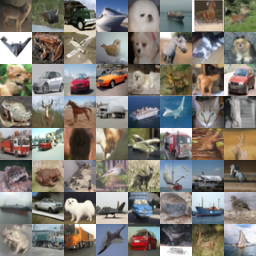

Generated batch of optimal images: (the optimal solution leads to images from the dataset)


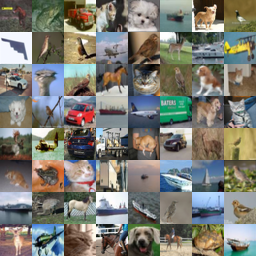

In [5]:
inter_xt = torch.tensor(stat['inter_xt'])
inter_denoised = torch.tensor(stat['inter_denoised'])

print('Generated batch of images:')
utils.display_image_grid(inter_xt[-1])

if 'inter_xt_opt' in stat.keys():
    inter_xt_opt = torch.tensor(stat['inter_xt_opt'])
    print('Generated batch of optimal images: (the optimal solution leads to images from the dataset)')
    utils.display_image_grid(inter_xt_opt[-1])

# Sampled Trajectories
Fig.11 in our ICML'24 paper: **On the Trajectory Regularity of ODE-based Diffusion Sampling** (https://arxiv.org/abs/2405.11326)

One sampling trajectory: (the 2nd row of Fig.11 in our paper)


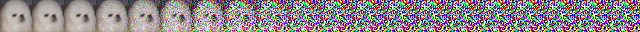

One denoising trajectory: (the 3rd row of Fig.11)


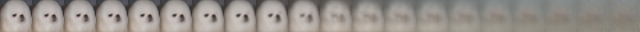

One sampling trajectory denoised by the optimal solution: (the 4th row of Fig.11)


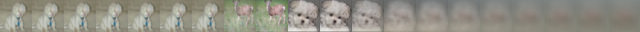

One optimal sampling trajectory: (the 5th row of Fig.11)


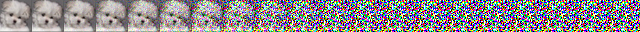

One optimal sampling trajectory denoised by network: (the 6th row of Fig.11)


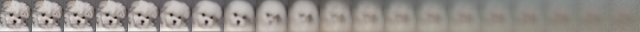

One optimal denoising trajectory: (the 7th row of Fig.11)


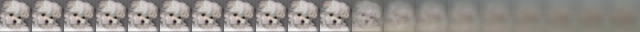

In [19]:
test_idx = 4

print('One sampling trajectory: (the 2nd row of Fig.11 in our paper)')
utils.display_image_grid(inter_xt[:-1,test_idx].flip(dims=(0,)), nrows=inter_xt[:,test_idx].shape[0])
print('One denoising trajectory: (the 3rd row of Fig.11)')
utils.display_image_grid(inter_denoised[:,test_idx].flip(dims=(0,)), nrows=inter_denoised[:,test_idx].shape[0])

if 'inter_xt_opt' in stat.keys():
    opt_denoised_traj = torch.tensor(stat['opt_denoised_traj'])
    denoised_opt_traj = torch.tensor(stat['denoised_opt_traj'])
    inter_denoised_opt = torch.tensor(stat['inter_denoised_opt'])
    
    print('One sampling trajectory denoised by the optimal solution: (the 4th row of Fig.11)')
    utils.display_image_grid(opt_denoised_traj[:,test_idx].flip(dims=(0,)), nrows=opt_denoised_traj[:,test_idx].shape[0])
    print('One optimal sampling trajectory: (the 5th row of Fig.11)')
    utils.display_image_grid(inter_xt_opt[:-1,test_idx].flip(dims=(0,)), nrows=inter_xt_opt[:,test_idx].shape[0])
    print('One optimal sampling trajectory denoised by network: (the 6th row of Fig.11)')
    utils.display_image_grid(denoised_opt_traj[:,test_idx].flip(dims=(0,)), nrows=denoised_opt_traj[:,test_idx].shape[0])
    print('One optimal denoising trajectory: (the 7th row of Fig.11)')
    utils.display_image_grid(inter_denoised_opt[:,test_idx].flip(dims=(0,)), nrows=inter_denoised_opt[:,test_idx].shape[0])

# Magnitude
Fig.18 in our paper: *A Geometric Perspective on Diffusion Models* (https://arxiv.org/abs/2305.19947)

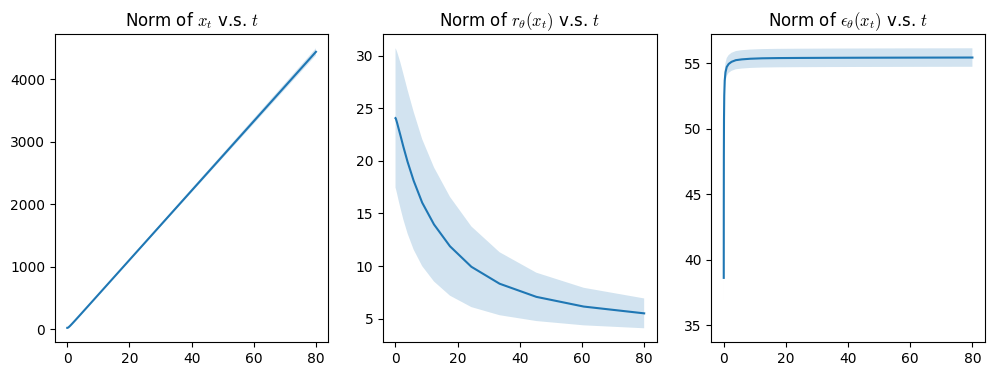

In [9]:
if 'mag_xt' in stat.keys():
    t_steps = stat['t_steps']

    mag_xt_mean, mag_xt_std = stat['mag_xt'].mean(axis=1), stat['mag_xt'].std(axis=1)
    mag_denoised_mean, mag_denoised_std = stat['mag_denoised'].mean(axis=1), stat['mag_denoised'].std(axis=1)
    mag_eps_mean, mag_eps_std = stat['mag_eps'].mean(axis=1), stat['mag_eps'].std(axis=1)
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].plot(t_steps, mag_xt_mean)
    axs[0].fill_between(t_steps, mag_xt_mean+mag_xt_std, mag_xt_mean-mag_xt_std, alpha=0.2)
    axs[0].set_title(r'Norm of $x_t$ v.s. $t$')
    
    axs[1].plot(t_steps[:-1], mag_denoised_mean)
    axs[1].fill_between(t_steps[:-1], mag_denoised_mean+mag_denoised_std, mag_denoised_mean-mag_denoised_std, alpha=0.2)
    axs[1].set_title(r'Norm of $r_{\theta}(x_t)$ v.s. $t$')
    
    axs[2].plot(t_steps[:-1], mag_eps_mean)
    axs[2].fill_between(t_steps[:-1], mag_eps_mean+mag_eps_std, mag_eps_mean-mag_eps_std, alpha=0.2)
    axs[2].set_title(r'Norm of ${\epsilon}_{\theta}(x_t)$ v.s. $t$')
    
    plt.show()

# Deviation
Fig.2b (red lines) in our paper: *A Geometric Perspective on Diffusion Models* (https://arxiv.org/abs/2305.19947)

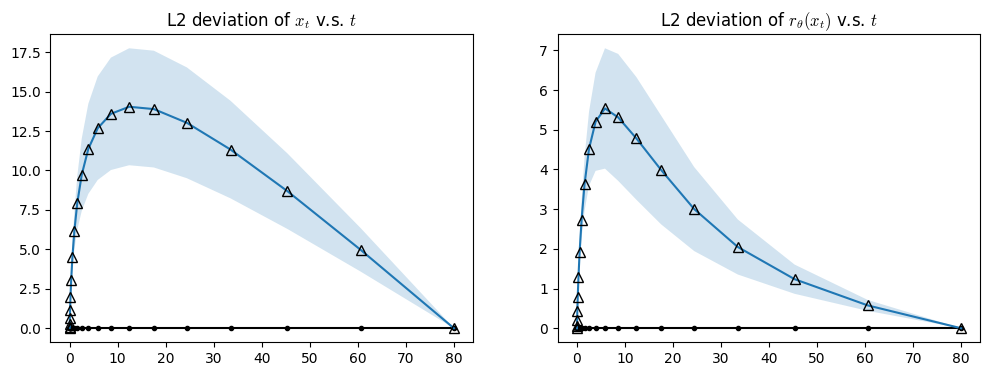

In [10]:
if 'dev_xt' in stat.keys():
    t_steps = stat['t_steps']

    dev_xt_mean, dev_xt_std = stat['dev_xt'].mean(axis=1), stat['dev_xt'].std(axis=1)
    dev_denoised_mean, dev_denoised_std = stat['dev_denoised'].mean(axis=1), stat['dev_denoised'].std(axis=1)
    t_temp = np.concatenate((t_steps, np.zeros(1,)))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    dev_xt_mean = np.concatenate((np.zeros(1,), dev_xt_mean, np.zeros(1,)))
    dev_xt_std = np.concatenate((np.zeros(1,), dev_xt_std, np.zeros(1,)))
    axs[0].plot(t_temp[0:-1], [0 for i in range(t_temp.shape[0]-1)], 'k', marker='o', markersize=3, markerfacecolor='black', markeredgecolor='black')
    axs[0].plot(t_temp[0:-1], dev_xt_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[0].fill_between(t_temp[0:-1], dev_xt_mean+dev_xt_std, dev_xt_mean-dev_xt_std, alpha=0.2)
    axs[0].set_title(r'L2 deviation of $x_t$ v.s. $t$')
    
    dev_denoised_mean = np.concatenate((np.zeros(1,), dev_denoised_mean, np.zeros(1,)))
    dev_denoised_std = np.concatenate((np.zeros(1,), dev_denoised_std, np.zeros(1,)))
    axs[1].plot(t_temp[0:-2], [0 for i in range(t_temp.shape[0]-2)], 'k', marker='o', markersize=3, markerfacecolor='black', markeredgecolor='black')
    axs[1].plot(t_temp[0:-2], dev_denoised_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[1].fill_between(t_temp[0:-2], dev_denoised_mean+dev_denoised_std, dev_denoised_mean-dev_denoised_std, alpha=0.2)
    axs[1].set_title(r'L2 deviation of $r_{\theta}(x_t)$ v.s. $t$')
    
    plt.show()


# Distance
Fig.2b (blue lines) in our paper: *A Geometric Perspective on Diffusion Models* (https://arxiv.org/abs/2305.19947)

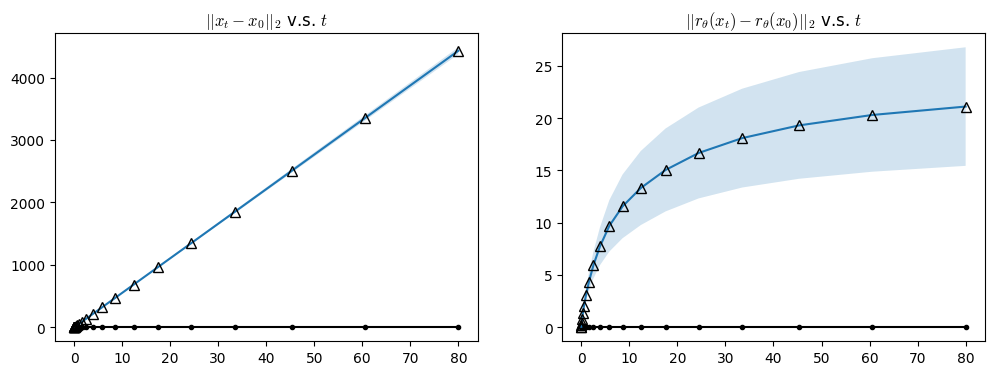

In [11]:
if 'dist_xt' in stat.keys():
    t_steps = stat['t_steps']

    dist_xt_mean, dist_xt_std = stat['dist_xt'].mean(axis=1), stat['dist_xt'].std(axis=1)
    dist_denoised_mean, dist_denoised_std = stat['dist_denoised'].mean(axis=1), stat['dist_denoised'].std(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    axs[0].plot(t_steps, [0 for i in range(t_steps.shape[0])], 'k', marker='o', markersize=3, markerfacecolor='black', markeredgecolor='black')
    axs[0].plot(t_steps, dist_xt_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[0].fill_between(t_steps, dist_xt_mean+dist_xt_std, dist_xt_mean-dist_xt_std, alpha=0.2)
    axs[0].set_title(r'$|| x_t - x_0 ||_2$ v.s. $t$')
    
    axs[1].plot(t_steps[0:-1], [0 for i in range(t_steps.shape[0]-1)], 'k', marker='o', markersize=3, markerfacecolor='black', markeredgecolor='black')
    axs[1].plot(t_steps[0:-1], dist_denoised_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[1].fill_between(t_steps[0:-1], dist_denoised_mean+dist_denoised_std, dist_denoised_mean-dist_denoised_std, alpha=0.2)
    axs[1].set_title(r'$|| r_{\theta}(x_t) - r_{\theta}(x_0) ||_2$ v.s. $t$')
    
    plt.show()


# Cosine 
Fig.14 in our paper: *A Geometric Perspective on Diffusion Models* (https://arxiv.org/abs/2305.19947)

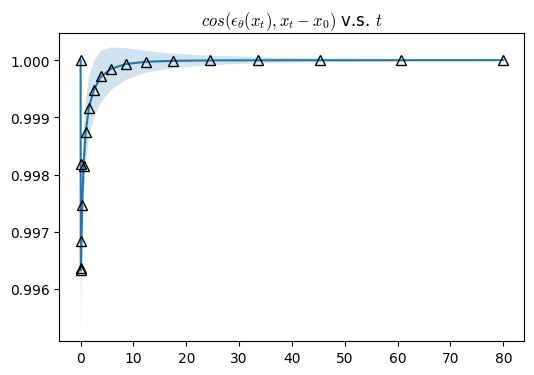

In [12]:
if 'cos_xt' in stat.keys():
    t_steps = stat['t_steps']

    cos_xt_mean, cos_xt_std = stat['cos_xt'].mean(axis=1), stat['cos_xt'].std(axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    ax.plot(t_steps[:-1], cos_xt_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    ax.fill_between(t_steps[:-1], cos_xt_mean+cos_xt_std, cos_xt_mean-cos_xt_std, alpha=0.2)
    ax.set_title(r'$cos(\epsilon_{\theta}(x_t), x_t - x_0)$ v.s. $t$')
    
    plt.show()

# Deviation to the Optima
Fig.14 in our paper: *A Geometric Perspective on Diffusion Models* (https://arxiv.org/abs/2305.19947)

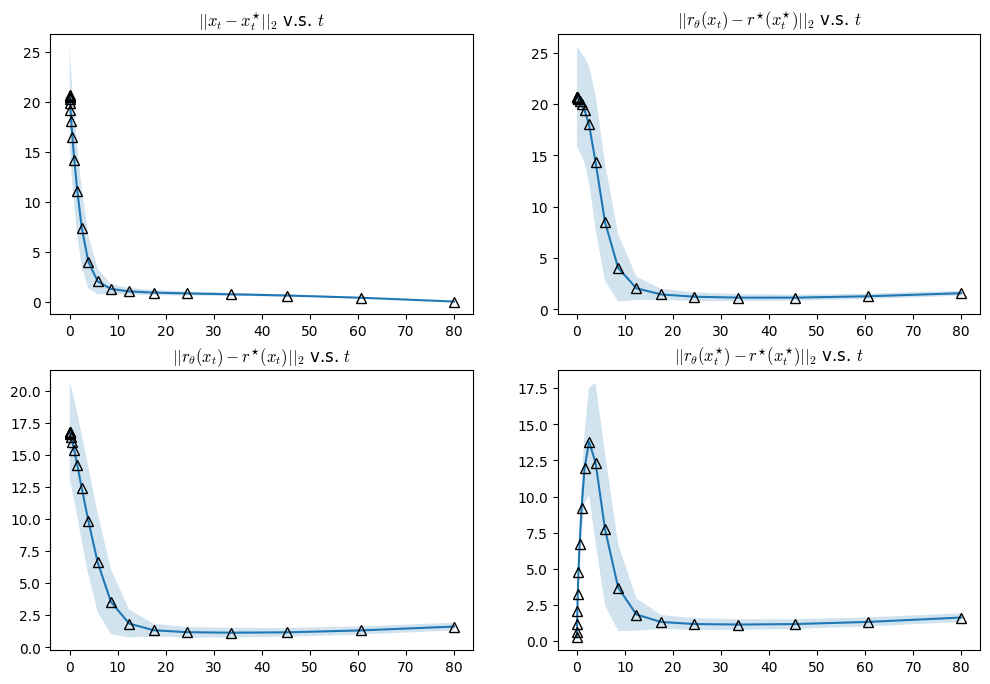

In [13]:
if 'diff_sample_traj' in stat.keys():
    t_steps = stat['t_steps']

    diff_sample_traj_mean, diff_sample_traj_std = stat['diff_sample_traj'].mean(axis=1), stat['diff_sample_traj'].std(axis=1)
    diff_denoised_traj_mean, diff_denoised_traj_std = stat['diff_denoised_traj'].mean(axis=1), stat['diff_denoised_traj'].std(axis=1)
    diff_traj_mean, diff_traj_std = stat['diff_traj'].mean(axis=1), stat['diff_traj'].std(axis=1)
    diff_opt_traj_mean, diff_opt_traj_std = stat['diff_opt_traj'].mean(axis=1), stat['diff_opt_traj'].std(axis=1)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0][0].plot(t_steps, diff_sample_traj_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[0][0].fill_between(t_steps, diff_sample_traj_mean+diff_sample_traj_std, diff_sample_traj_mean-diff_sample_traj_std, alpha=0.2)
    axs[0][0].set_title(r'$|| x_t - x_t^{\star} ||_2$ v.s. $t$')
    
    axs[0][1].plot(t_steps[0:-1], diff_denoised_traj_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[0][1].fill_between(t_steps[0:-1], diff_denoised_traj_mean+diff_denoised_traj_std, diff_denoised_traj_mean-diff_denoised_traj_std, alpha=0.2)
    axs[0][1].set_title(r'$|| r_{\theta}(x_t) - r^{\star}(x_t^{\star}) ||_2$ v.s. $t$')
    
    axs[1][0].plot(t_steps[0:-1], diff_traj_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[1][0].fill_between(t_steps[0:-1], diff_traj_mean+diff_traj_std, diff_traj_mean-diff_traj_std, alpha=0.2)
    axs[1][0].set_title(r'$|| r_{\theta}(x_t) - r^{\star}(x_t) ||_2$ v.s. $t$')
    
    axs[1][1].plot(t_steps[0:-1], diff_opt_traj_mean, marker='^', markersize=7, fillstyle='none', markeredgecolor='black')
    axs[1][1].fill_between(t_steps[0:-1], diff_opt_traj_mean+diff_opt_traj_std, diff_opt_traj_mean-diff_opt_traj_std, alpha=0.2)
    axs[1][1].set_title(r'$|| r_{\theta}(x_t^{\star}) - r^{\star}(x_t^{\star}) ||_2$ v.s. $t$')
    
    plt.show()
